In [48]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Bosch Project").getOrCreate()

In [49]:
spark

In [3]:
import time
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Through previous EDA step, we notice that:
* For ***numerical*** features, the number of features is 970.
* For ***categorical*** features, the number of features is 2141.
* For ***date*** features, the number of features is 1157.
* A lot of features in date dataset are duplicate. Unique columns are: 
`['L3_S37_D3949', 'L3_S30_D3541', 'L3_S29_D3428', 'L3_S34_D3877', 'L3_S33_D3870', 'L0_S0_D3', 'L0_S1_D30', 'L0_S8_D145', 'L3_S36_D3919', 'L3_S35_D3910', 'L0_S5_D115', 'L0_S3_D70', 'L0_S6_D120', 'L0_S7_D143', 'L0_S2_D54', 'L0_S4_D106', 'L0_S12_D333', 'L0_S20_D465', 'L0_S13_D355', 'L0_S10_D266', 'L0_S11_D284', 'L0_S9_D192', 'L2_S26_D3084', 'L1_S24_D1828', 'L0_S19_D457', 'L0_S17_D432', 'L0_S14_D380', 'L0_S15_D401', 'L0_S16_D428', 'L2_S27_D3156', 'L0_S18_D447', 'L0_S21_D469', 'L0_S23_D629', 'L0_S22_D608', 'L3_S41_D4021', 'L3_S40_D3981', 'L3_S45_D4129', 'L3_S48_D4203', 'L3_S47_D4155', 'L3_S39_D3974', 'L3_S51_D4255', 'L1_S25_D1887', 'L3_S31_D3848', 'L3_S43_D4097', 'L3_S49_D4208', 'L3_S50_D4254', 'L3_S44_D4122', 'L3_S38_D3953', 'L3_S32_D3852', 'L2_S28_D3234', 'L3_S46_D4135', 'L3_S42_D4057']`
* Average failure rate is **0.58%** which implies that our target is highly skewed.

# Numerical Feature Engineering

In [4]:
num = spark.read\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .format('csv')\
  .load('train_numeric.csv')

"cat = spark.read  .option('header', 'true')  .option('inferSchema', 'true')  .format('csv')  .load('train_categorical.csv')\n\ndate = spark.read  .option('header', 'true')  .option('inferSchema', 'true')  .format('csv')  .load('train_date.csv')"

In [5]:
num_pd = pd.read_csv('train_numeric.csv')

In [7]:
num_pd_t = num_pd.head(10000)

In [8]:
features = num_pd.drop(['Response', 'Id'], axis=1).columns.values

In [10]:
def organize(features):
    line_features = {}
    station_features = {}
    lines = set([f.split('_')[0] for f in features])
    stations = set([f.split('_')[1] for f in features])
    
    for l in lines:
        line_features[l] = [f for f in features if l+'_' in f]
        
    for s in stations:
        station_features[s] = [f for f in features if s+'_' in f]
        
            
    return line_features, station_features

line_features, station_features = organize(features)

# Eg. Feature for station 32 will be feature 3850
print("Features in Station 32: {}".format( station_features['S32'] ))

Features in Station 32: ['L3_S32_F3850']


In [11]:
station_error = []
for s in station_features:
    cols = ['Id', 'Response']
    cols.extend(station_features[s])
    df = num_pd_t.dropna(subset=station_features[s], how='all')
    error_rate = df[df.Response == 1].size / float(df[df.Response == 0].size)
    station_error.append([df.shape[1]-2, df.shape[0], error_rate]) 
    
station_data = pd.DataFrame(station_error, 
                         columns=['Features', 'Samples', 'Error_Rate'], 
                         index=station_features).sort_index()

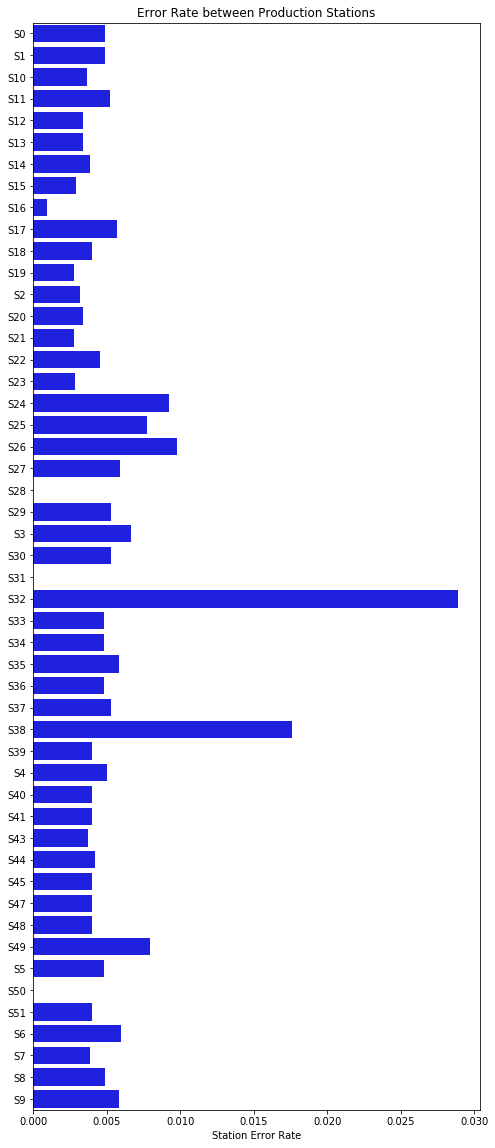

In [12]:
plt.figure(figsize=(8, 20))
sns.barplot(x='Error_Rate', y=station_data.index.values, data=station_data, color="blue")
plt.title('Error Rate between Production Stations')
plt.xlabel('Station Error Rate')
plt.show()

From plot above, we notice that station 32 and 38 have distinctively high failure rate with station 24,26 and 49,6 following.

In [13]:
data = num_pd

def make_features(df):
    new_features = pd.DataFrame({})
    for s in station_features.keys():
        station_data = df[station_features[s]]
        col = s+'_max'
        new_features[col] = station_data.max(axis=1).fillna(-1.)
        col = s+'_min'
        new_features[col] = station_data.min(axis=1).fillna(-1.)
    return new_features

data = make_features(data)

In [14]:
Id_ = pd.DataFrame(num_pd['Id'])

In [15]:
new_df_numerical = pd.concat([Id_,data],axis=1)

In [16]:
new_df_numerical.head()

,Id,S2_max,S2_min,S19_max,S19_min,S17_max,S17_min,S1_max,S1_min,S34_max,...,S20_max,S20_min,S31_max,S31_min,S36_max,S36_min,S51_max,S51_min,S9_max,S9_min
0,4,0.010,-0.223,-1.0,-1.0,-1.0,-1.0,0.167,-0.271,0.0,...,-1.0,-1.000,0.002,-0.049,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
1,6,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.000,-1.000,0.0,...,0.0,-0.197,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
2,7,0.011,-0.223,-1.0,-1.0,-1.0,-1.0,0.057,-0.079,0.0,...,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
3,9,0.120,-0.231,-1.0,-1.0,-1.0,-1.0,0.147,-0.007,0.0,...,-1.0,-1.000,-1.000,-1.000,0.000,-0.192,-1.0,-1.0,-1.0,-1.0
4,11,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-0.012,-0.046,0.0,...,-1.0,-1.000,-1.000,-1.000,0.083,-0.092,-1.0,-1.0,-1.0,-1.0


In [18]:
new_df_numerical.to_csv('new_train_numerical.csv')

# Categorical Feature Engineering

In [66]:
cat = spark.read\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .format('csv')\
  .load('train_categorical.csv')

In [67]:
dfcat = cat.createOrReplaceTempView("dfcat")

In [69]:
spark.sql('SELECT * FROM dfcat LIMIT 5').show()

+---+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------

In [73]:
cat_pd = pd.DataFrame(cat.head(10000),columns=cat.columns)

In [82]:
for k, v in cat_pd.nunique().to_dict().items():
    if v > 3:
        print('{}={}'.format(k,v))

Id=10000
L1_S24_F1114=4
L1_S24_F1137=4
L1_S24_F1140=4
L1_S24_F1510=5
L1_S24_F1525=5
L1_S24_F1530=5
L1_S25_F1852=5
L1_S25_F2779=5
L3_S32_F3854=14


In [83]:
cat_columns = ['L1_S24_F1114','L1_S24_F1137','L1_S24_F1140','L1_S24_F1510','L1_S24_F1525','L1_S24_F1530','L1_S25_F1852','L1_S25_F2779','L3_S32_F3854']

In [84]:
cat_df = pd.read_csv('train_categorical.csv',usecols=cat_columns) 

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (576,588,590,807,811,815,984,1429,1987) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [85]:
cat_df.to_csv('new_train_cat.csv')

# Date Feature Engineering

In [61]:
date_columns = ['L3_S37_D3949', 'L3_S30_D3541', 'L3_S29_D3428', 'L3_S34_D3877', 'L3_S33_D3870', 'L0_S0_D3', 'L0_S1_D30', 'L0_S8_D145', 'L3_S36_D3919', 'L3_S35_D3910', 'L0_S5_D115', 'L0_S3_D70', 'L0_S6_D120', 'L0_S7_D143', 'L0_S2_D54', 'L0_S4_D106', 'L0_S12_D333', 'L0_S20_D465', 'L0_S13_D355', 'L0_S10_D266', 'L0_S11_D284', 'L0_S9_D192', 'L2_S26_D3084', 'L1_S24_D1828', 'L0_S19_D457', 'L0_S17_D432', 'L0_S14_D380', 'L0_S15_D401', 'L0_S16_D428', 'L2_S27_D3156', 'L0_S18_D447', 'L0_S21_D469', 'L0_S23_D629', 'L0_S22_D608', 'L3_S41_D4021', 'L3_S40_D3981', 'L3_S45_D4129', 'L3_S48_D4203', 'L3_S47_D4155', 'L3_S39_D3974', 'L3_S51_D4255', 'L1_S25_D1887', 'L3_S31_D3848', 'L3_S43_D4097', 'L3_S49_D4208', 'L3_S50_D4254', 'L3_S44_D4122', 'L3_S38_D3953', 'L3_S32_D3852', 'L2_S28_D3234', 'L3_S46_D4135', 'L3_S42_D4057']

In [63]:
date_df = pd.read_csv('train_date.csv',usecols=date_columns) 

In [58]:
# date_pd = pd.DataFrame(new_date.head(10000),columns=new_date.columns)

# date = spark.read\
#   .option('header', 'true')\
#   .option('inferSchema', 'true')\
#   .format('csv')\
#   .load('train_date.csv')

In [65]:
date_df.to_csv('new_train_date.csv')

In [86]:
spark.stop()